Machine Learning Engineer Nanodegree
Capstone Project
Stock market price prediction

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from preprocessor import PCAComponents
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from math import ceil
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#custom modules
import helpers
import featurecomposer
from preprocessor import FeatureImportance, RemoveOutliers, Normalize
from stockdataloader import StockDataLoader
from stockdatavisual import PlotR2Score


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\fix_yahoo_finance\__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and no longer available.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)


Load data 

In [2]:
#init parameters
stockData_begin = '2005-01-01'
processing_tokens = ['AAPL', 'MSFT', 'ACN', 'GOOG', 'CSCO', 'EBAY', 'EA', 'HP', 'IBM', 'INTC', 'SPY']

#INIT
#import/update stock data
stockData = StockDataLoader(stockData_begin, datetime.datetime.now().strftime("%Y-%m-%d"), tickers = processing_tokens)
stockData.LoadData(update_data_online = False)

stockData.raw_financial_data['SPY'][['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].head(5)

---Building calendar for the period from 2005-01-01 to 2018-01-27
===Calendar is created
---Loading local data
===Local data is loaded
---Optimizing
===Optimizing is finished


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
20050103,121.559998,121.760002,119.900002,120.300003,92.936493,55748000
20050104,120.459999,120.540001,118.440002,118.830002,91.800850,69167600
20050105,118.739998,119.250000,118.000000,118.010002,91.167374,65667300
20050106,118.440002,119.150002,118.260002,118.610001,91.630920,47814700
20050107,118.970001,119.230003,118.129997,118.440002,91.499573,55847700


Exploratory analysis

In [3]:
stockData.raw_financial_data['SPY'][['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].describe()

,Open,High,Low,Close,Adj Close,Volume
count,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3.288000e+03
mean,155.497317,156.313926,154.595884,155.510514,139.593775,1.485924e+08
std,44.920534,44.865168,44.979332,44.947541,50.721176,1.015990e+08
min,67.949997,70.000000,67.099998,68.110001,56.879089,1.527000e+07
25%,123.052498,123.610001,122.374998,122.992499,100.737060,7.658900e+07
50%,140.404998,141.175003,139.805001,140.534996,118.300007,1.201130e+08
75%,195.715004,196.755001,194.930000,195.827507,185.098446,1.876610e+08
max,284.019989,284.700012,282.369995,283.290009,283.290009,8.710263e+08


Exploratory visualizations

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


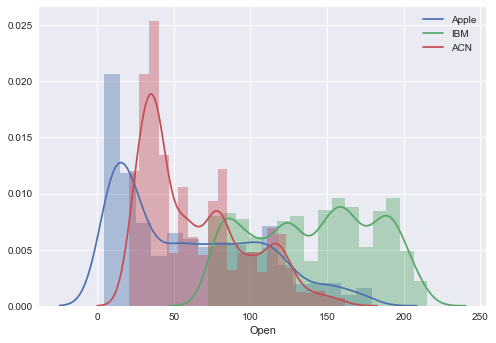

In [4]:
sns.set(color_codes=True)
x = np.random.normal(size=100)
sns.distplot(stockData.raw_financial_data['AAPL']['Open'], kde_kws={"label": "Apple"});
sns.distplot(stockData.raw_financial_data['IBM']['Open'], kde_kws={"label": "IBM"});
sns.distplot(stockData.raw_financial_data['ACN']['Open'], kde_kws={"label": "ACN"});
plt.show()

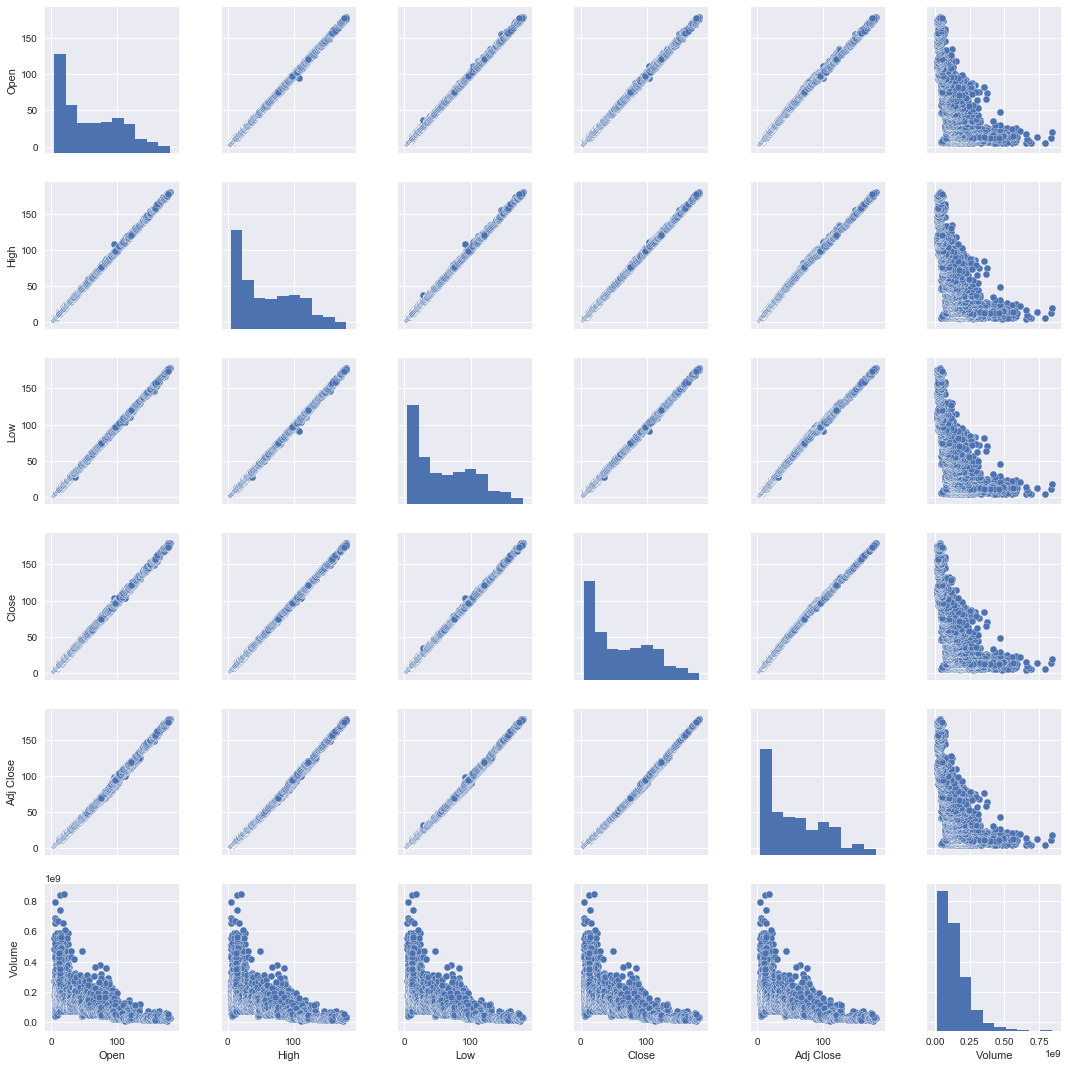

In [5]:
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

sns.pairplot(stockData.raw_financial_data['AAPL'][cols], size=2.5)
plt.tight_layout()

plt.show()

Data observations
All numerical features except Volume are correlated. That is explained by the nature of the data - in most cases we do not expect to see Close price to be significantly different from Open price, unless major disturbance affects the market. 
Closer examination of the distributions that belong to different companies reveals different patterns – scale, distribution, outliers. For example, Apple Open price distribution is significantly skewed to the right and have fair amount of outliers whereas IBM distribution is flat with no outliers.


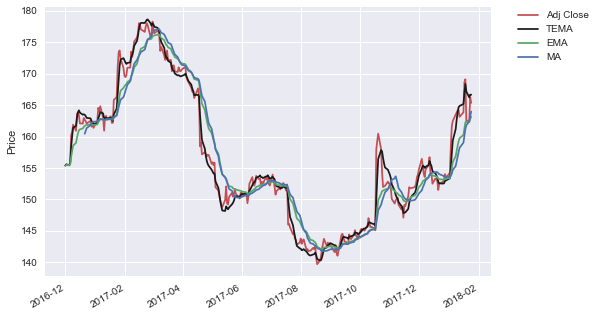

In [6]:
def CalcTEMA(values, window):
    EMA1 = CalcEMA(values, window)
    EMA2 = CalcEMA(EMA1, window)
    EMA3 = CalcEMA(EMA2, window)
    TEMA = 3*EMA1 - 3*EMA2 + EMA3
    return TEMA
    
def CalcEMA(values, window):
    '''Expotentia moving average'''
    ema = values.ewm(span = window).mean()
    return ema

def CalcMovingAvg( values, window):
    '''Simple moving average'''
    sma = values.rolling(window=window, center=False).mean()
    return sma  

ibm_df = stockData.raw_financial_data['IBM'][3000:].copy()
source_feature = 'Adj Close'
window = 15

ibm_df['EMA'] = CalcEMA(ibm_df[source_feature], window)
ibm_df['MA'] = CalcMovingAvg(ibm_df[source_feature], window)
ibm_df['TEMA'] = CalcTEMA(ibm_df[source_feature], window)

days = [datetime.datetime.strptime((str(element)[0:4] + '-' + str(element)[4:6] + '-' + str(element)[6:8]), '%Y-%m-%d').date()
        for element in ibm_df.index]
adj_close = ibm_df['Adj Close']
TEMA = ibm_df['TEMA']
MA = ibm_df['MA']
EMA = ibm_df['EMA']

fig = plt.figure()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9 
plt.plot_date(x=days, y=adj_close,fmt="r-", label='Adj Close')
plt.plot_date(x=days, y=TEMA,fmt="k-")
plt.plot_date(x=days, y=EMA,fmt="g-")
plt.plot_date(x=days, y=MA,fmt="b-")
fig.autofmt_xdate()
plt.ylabel("Price")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

High volatility of our target variable Adj Close could lead low accuracy of the prediction and potential lost opportunity to enter. Comparing behavior of Adj Close with its moving averages MA, EMA and TEMA we can see that MA and EMA are slightly behind our target variable, but TEMA is a good approximation of it. With that, we use TEMA (triple exponential moving average) indicator of Adj Close as an output variable.

Feature engineering

In [7]:
indicators = [
               'Open'
               ,'Close'
               ,'High'
               ,'Low'
               ,'Volume'
               ,'ROC'
               ,'VIX'
               ,'CCI'
               ,'WILLR'
               ,'MA', 'D_MA5', 'D_MA10'
               ,'RSI', 'D_RSI5', 'D_RSI10'
               ,'BIAS', 'D_BIAS5', 'D_BIAS10'
               ,'EMA', 'D_EMA5', 'D_EMA10'
               ,'Adj Close'
               ,'EMA_COEFF'
               ,'TEMA', 'D_TEMA5', 'D_TEMA10'    
             ]

pack_size = 3
injecting_tokens = ['SPY']
pred_indicator = 'TEMA'
predicting_day_index = 1
predict_change = True
base_features_absolute = False

fc = featurecomposer.FeatureComposer(stockdata_dict = stockData.raw_financial_data, indicators = indicators, 
                                     pred_indicator = pred_indicator, pack_size = pack_size, 
                                     injecting_tokens = injecting_tokens, base_features_absolute = base_features_absolute,
                                     log_transform = True)

fc.Compose()

model_training_start_index = 2000
model_training_end_index = 2800
model_validation_start_index = 1000
model_validation_end_index = 2000

features_all = {}
training_all = {}
validation_all = {}
for ticker in processing_tokens:
    features, labels, date_indexes = fc.GetData(ticker, predicting_day_index = predicting_day_index, 
                                                predict_change = predict_change)
    features_all[ticker] = [features, labels, date_indexes]
    training_all[ticker] = [features[model_training_start_index:model_training_end_index], 
                            labels[model_training_start_index:model_training_end_index], date_indexes]
    validation_all[ticker] = [features[model_validation_start_index:model_validation_end_index], 
                            labels[model_validation_start_index:model_validation_end_index], date_indexes]

Composer - Extracting features


featurecomposer.py:306: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  RolUp = pd.rolling_mean(dUp, window)
featurecomposer.py:296: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).std()
  CCI = pd.Series((TP - pd.rolling_mean(TP, window)) / (0.015 * pd.rolling_std(TP, window)))
C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\series.py:1295: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)
featurecomposer.py:187: RuntimeWarning: invalid value encountered in sign
  df = df[[s for s in df.columns.tolist() if s != 'Weekday' and s != 'Token' and s != 'Label']].apply(lambda x: np.sign(x) * np.log(np.absolute(x) + 1))


Composer - Packing features
Composer - Injecting features
Composer - Combining datasets
Composer - DONE


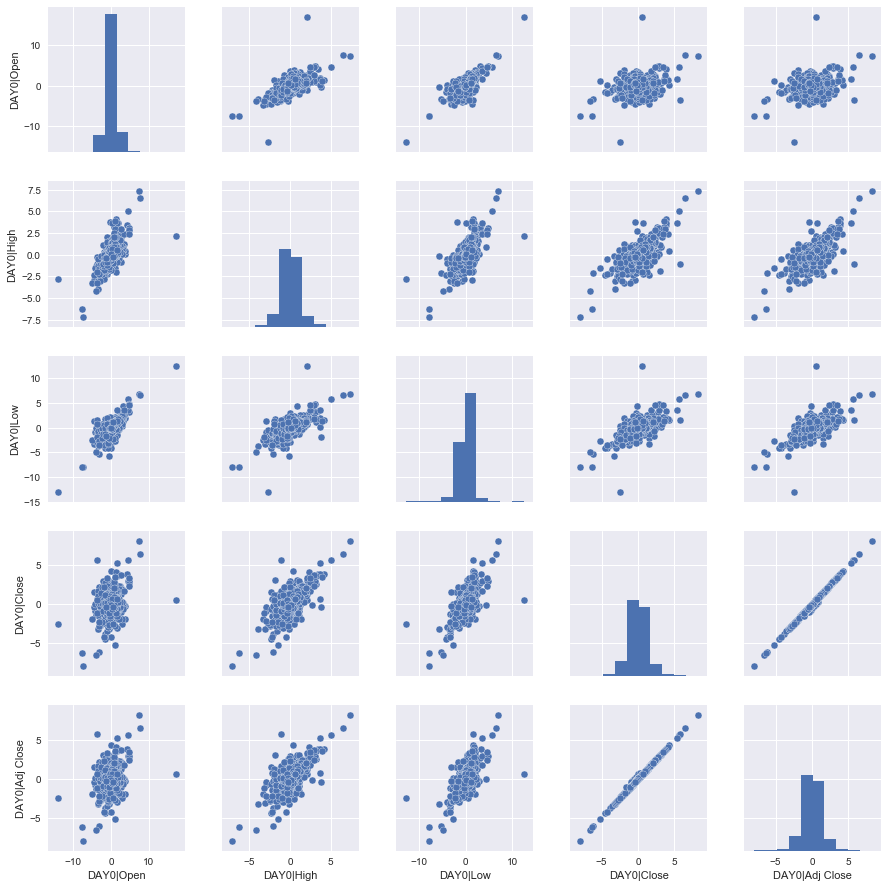

In [8]:
ticker = 'AAPL'

corr_coeff_set = training_all[ticker][0]
cols = [c for c in corr_coeff_set.columns.tolist() if c[:4] == 'DAY0']

sns.pairplot(corr_coeff_set[cols[:5]], size=2.5)
plt.tight_layout()

plt.show()

During the data engineering phase we introduced new set of features derived from basic attributes:
    'Open'
    'Close'
    'High'
    'Low'
    'Volume'
    'ROC'
    'VIX'
    'CCI'
    'WILLR'
    'MA', 'D_MA5', 'D_MA10'
    'RSI', 'D_RSI5', 'D_RSI10'
    'BIAS', 'D_BIAS5', 'D_BIAS10'
    'EMA', 'D_EMA5', 'D_EMA10'
    'Adj Close'
    'EMA_COEFF'
    'TEMA', 'D_TEMA5', 'D_TEMA10'

Using log-transformation we were able to slightly reduce the number of outliers and make data more uniformly distributed.
Certain new features have no values assigned due to lack of historical information. 
All datapoints with missing or unknown attributes are removed from dataset.

Extracting important features along with PCA reduction are major tools to filter features that fit given stock and lower overfitting of the model

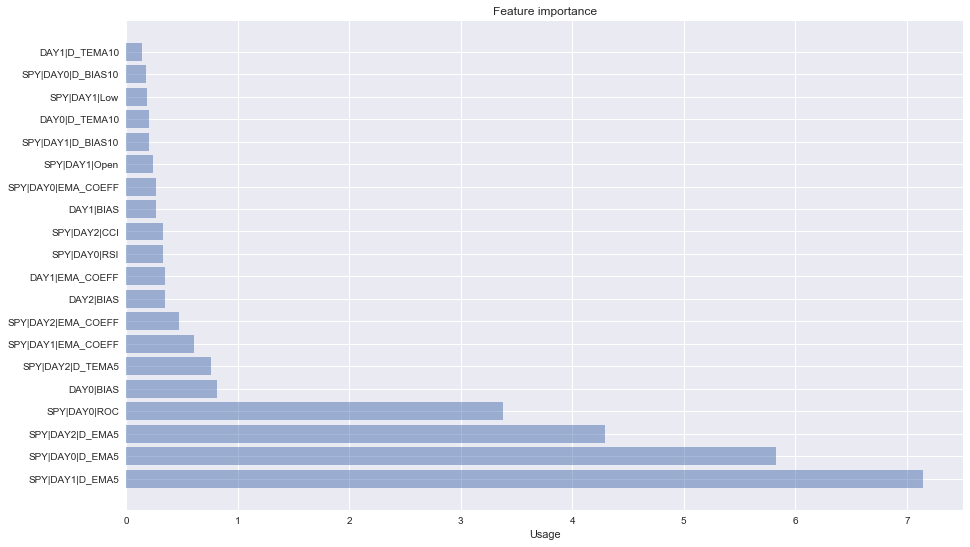

In [9]:
#extracting important features
n_epochs = 30

feature_importance_train = training_all[ticker][0]
feature_importance_labels = training_all[ticker][0]

important_feature_list = FeatureImportance(feature_importance_train[:300], feature_importance_labels[:300], 
                                           n_epochs = n_epochs, show_plot = True, max_size = 20)


As expected most recent value of the predicting indicator impacts the prediction the most

The profile of PCA principal components is below.

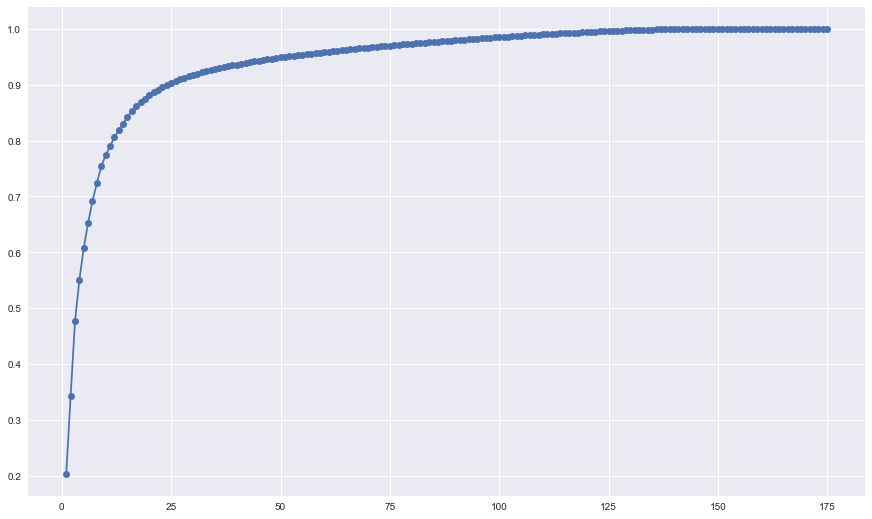

In [10]:
#get features and labels
features_benchmark = training_all[ticker][0]
labels_benchmark = training_all[ticker][1]
date_indexes_benchmark = training_all[ticker][2]
#Normalize and remove outliers
features_benchmark, features_benchmark = Normalize(features_benchmark, features_benchmark)
features_benchmark, labels_benchmark = RemoveOutliers(features_benchmark, labels_benchmark, residual_threshold = 1.5) 
#Assign X,y
X_train_benchmark = features_benchmark
y_train_benchmark = labels_benchmark

x = np.arange(1, X_train_benchmark.shape[1] + 1)
pca = PCA()
pca.fit(X_train_benchmark)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), '-o')

Benchmark model
We use most important features obtained from 'feature importance' above to run RandomForestRegressor.
The learning covers the period 2015-12-30 to 2017-08-01.
TimeSeriesSplit cross validation is used to evaluate the performance on multiple folds
R^2 score is used to determine the algorithm's generalization power.

In [11]:
def ResultOutput(dataframe):
    df = dataframe.copy()
    idx = df.groupby(['Ticker'])['R2 test'].transform(max) == df['R2 test']
    df = df[idx]
    print(df)

In [18]:
scores = []
for ticker in processing_tokens[:]:
    print(ticker)

    #get features and labels
    features_benchmark = training_all[ticker][0]
    labels_benchmark = training_all[ticker][1]
    date_indexes_benchmark = training_all[ticker][2]
    #Normalize and remove outliers
    features_benchmark, features_benchmark = Normalize(features_benchmark, features_benchmark)
    features_benchmark, labels_benchmark = RemoveOutliers(features_benchmark, labels_benchmark, residual_threshold = 1.5) 
    #Assign X,y
    X_train_benchmark = features_benchmark
    y_train_benchmark = labels_benchmark
    #sequential train/test split 
    tscv = TimeSeriesSplit(n_splits=20)    
    regressor = RandomForestRegressor(n_estimators = 512, max_depth = 30, min_samples_leaf = 3)    
    regressor = RandomForestRegressor()    
    pipe_lr = Pipeline([
                    ('rgr', regressor)
                   ])
    start = time()    
    cvs_score = cross_validate(estimator=pipe_lr, 
                      X = X_train_benchmark,
                      y = y_train_benchmark,
                      scoring=('r2', 'neg_mean_squared_error'),
                      cv = tscv,
                      n_jobs =-1)
    end = time()       
    scores.append([regressor.__class__.__name__, ticker, end - start, 
                       np.mean(np.array(cvs_score['train_r2'])),
                       np.absolute(np.mean(np.array(cvs_score['train_neg_mean_squared_error']))),
                       np.mean(np.array(cvs_score['test_r2'])),
                       np.absolute(np.mean(np.array(cvs_score['test_neg_mean_squared_error'])))
                      ])
benchmark_df = pd.DataFrame(scores, columns=['Algorithm','Ticker','Time','R2 train','MSE train','R2 test','MSE test'])
ResultOutput(benchmark_df)

AAPL
MSFT
ACN
GOOG
CSCO
EBAY
EA
HP
IBM
INTC
SPY
                Algorithm Ticker    Time  R2 train  MSE train   R2 test  \
0   RandomForestRegressor   AAPL   8.831  0.909679   0.030597  0.409565   
1   RandomForestRegressor   MSFT  10.902  0.876075   0.010196  0.168421   
2   RandomForestRegressor    ACN   8.713  0.877930   0.020055  0.313718   
3   RandomForestRegressor   GOOG   8.160  0.960744   0.194784  0.610884   
4   RandomForestRegressor   CSCO   8.894  0.902656   0.002261  0.286277   
5   RandomForestRegressor   EBAY   8.997  0.881131   0.003408  0.115799   
6   RandomForestRegressor     EA   8.822  0.899419   0.015347  0.280475   
7   RandomForestRegressor     HP   8.641  0.890435   0.042955  0.231619   
8   RandomForestRegressor    IBM   8.811  0.911953   0.047300  0.319440   
9   RandomForestRegressor   INTC   9.313  0.896783   0.005094  0.239553   
10  RandomForestRegressor    SPY   8.590  0.898680   0.034299  0.287117   

    MSE test  
0   0.213876  
1   0.070800  
2   0.

We observing very poor result from our benchmark model RandomForestRegressor

Run learning on selected regression algorithm using same dataset as the one we used for benchmarking.


In [12]:
regressors = {'rgr1':LinearRegression(), 'rgr2': Ridge(),
              'rgr3':Lasso(), 'rgr4':AdaBoostRegressor(), 'rgr5':SVR()}

scores = []
for ticker in processing_tokens[:]:
    print(ticker)
    #get features and labels
    features_base = training_all[ticker][0]
    labels_base = training_all[ticker][1]
    date_indexes_base = training_all[ticker][2]
    #Normalize and remove outliers    
    features_base, labels_base = RemoveOutliers(features_base, labels_base, residual_threshold = 1.5)
    features_base, features_base = Normalize(features_base, features_base)
    #Assign X,y
    X_train_base = features_base
    y_train_base = labels_base
    #sequential train/test split 
    tscv = TimeSeriesSplit(n_splits=20)
    #run a baseline regressor algorithm for each ticker
    for rgr in regressors:
        regressor = regressors[rgr]
        pipe_lr = Pipeline([
                        #('nrm', MinMaxScaler()),
                        ('pca', PCA(n_components = 20)),
                        ('rgr', regressor)
                       ])        
        start = time() 
        cvs_score = cross_validate(estimator=pipe_lr, 
                      X = X_train_base,
                      y = y_train_base,
                      scoring=('r2', 'neg_mean_squared_error'),
                      cv = tscv,
                      n_jobs =-1)
        end = time()
        scores.append([
                       regressor.__class__.__name__, ticker, end - start, 
                       np.mean(np.array(cvs_score['train_r2'])),
                       np.absolute(np.mean(np.array(cvs_score['train_neg_mean_squared_error']))),
                       np.mean(np.array(cvs_score['test_r2'])),
                       np.absolute(np.mean(np.array(cvs_score['test_neg_mean_squared_error'])))
                      ])

scores_baseline = pd.DataFrame(scores, columns=['Algorithm','Ticker','Time','R2 train','MSE train','R2 test','MSE test'])
ResultOutput(scores_baseline)

AAPL


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


MSFT
ACN
GOOG
CSCO
EBAY
EA
HP
IBM
INTC
SPY
           Algorithm Ticker   Time  R2 train  MSE train   R2 test  MSE test
4   LinearRegression   AAPL  8.094  0.608843   0.140312  0.475338  0.204147
8              Ridge   MSFT  8.069  0.463478   0.045229  0.301192  0.062194
14  LinearRegression    ACN  8.297  0.519818   0.083450  0.361423  0.133181
19  LinearRegression   GOOG  8.783  0.744636   1.131834  0.500716  1.934933
23             Ridge   CSCO  8.012  0.574132   0.010135  0.338379  0.014508
28             Ridge   EBAY  8.121  0.474370   0.015024  0.307777  0.021038
33             Ridge     EA  8.101  0.533541   0.073329  0.286187  0.139760
39  LinearRegression     HP  8.159  0.535361   0.192751  0.339801  0.258507
43             Ridge    IBM  8.276  0.567082   0.228223  0.401270  0.249930
45               SVR   INTC  8.159  0.481029   0.024914  0.317002  0.032009
50               SVR    SPY  8.171  0.519295   0.163734  0.351663  0.220470


In [ ]:
def ResultOutput(dataframe):
    df = dataframe.copy()
    idx = df.groupby(['Ticker'])['R2 test'].transform(max) == df['R2 test']
    df = df[idx]
    print(df)

def PlotR2Score(df, title, score): 
    # data to plot
    n_groups = 5
    score_AAPL = df[(df['Ticker'] == 'AAPL')]['R2 test'].as_matrix().tolist()
    score_MSFT = df[(df['Ticker'] == 'MSFT')]['R2 test'].as_matrix().tolist()
    score_ACN = df[(df['Ticker'] == 'ACN')]['R2 test'].as_matrix().tolist()
    score_GOOG = df[(df['Ticker'] == 'GOOG')]['R2 test'].as_matrix().tolist()
    score_CSCO = df[(df['Ticker'] == 'CSCO')]['R2 test'].as_matrix().tolist()
    score_EBAY = df[(df['Ticker'] == 'EBAY')]['R2 test'].as_matrix().tolist()
    score_EA = df[(df['Ticker'] == 'EA')]['R2 test'].as_matrix().tolist()
    score_HP = df[(df['Ticker'] == 'HP')]['R2 test'].as_matrix().tolist()
    score_IBM = df[(df['Ticker'] == 'IBM')]['R2 test'].as_matrix().tolist()
    score_INTC = df[(df['Ticker'] == 'INTC')]['R2 test'].as_matrix().tolist()

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.05
    opacity = 0.8

    rectsAAPL = plt.bar(index, score_AAPL, bar_width, alpha=opacity,  label='AAPL') 
    rectsMSFT = plt.bar(index + bar_width, score_MSFT, bar_width, alpha=opacity, label='MSFT')
    rectsACN = plt.bar(index + 2 * bar_width, score_ACN, bar_width, alpha=opacity, label='ACN')
    rectsGOOG = plt.bar(index + 3 * bar_width, score_GOOG, bar_width, alpha=opacity, label='GOOG')
    rectsCSCO = plt.bar(index + 4 * bar_width, score_CSCO, bar_width, alpha=opacity, label='CSCO')
    rectsEBAY = plt.bar(index + 5 * bar_width, score_EBAY, bar_width, alpha=opacity, label='EBAY')
    rectsEA = plt.bar(index + 6 * bar_width, score_EA, bar_width, alpha=opacity, label='EA')
    rectsHP = plt.bar(index + 7 * bar_width, score_HP, bar_width, alpha=opacity, label='HP')
    rectsIBM = plt.bar(index + 8 * bar_width, score_IBM, bar_width, alpha=opacity, label='IBM')
    rectsINTC = plt.bar(index + 9 * bar_width, score_INTC, bar_width, alpha=opacity, label='INTC')

    legend = ax.legend(loc='lower center', bbox_to_anchor=(1.1, 0.2), shadow=True)
    plt.xlabel('Algorithm')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(index + bar_width, ('SVR', 'Ada', 'Lasso', 'Ridge', 'Linear'))
    if score == 'mse':
        plt.ylim(-0.25, np.max(df['Score'].as_matrix()) + 1)        
    else:
        plt.ylim(-0.25, 1)        
    plt.tight_layout()
    plt.show()


Visualize the performance of baseline algorithms

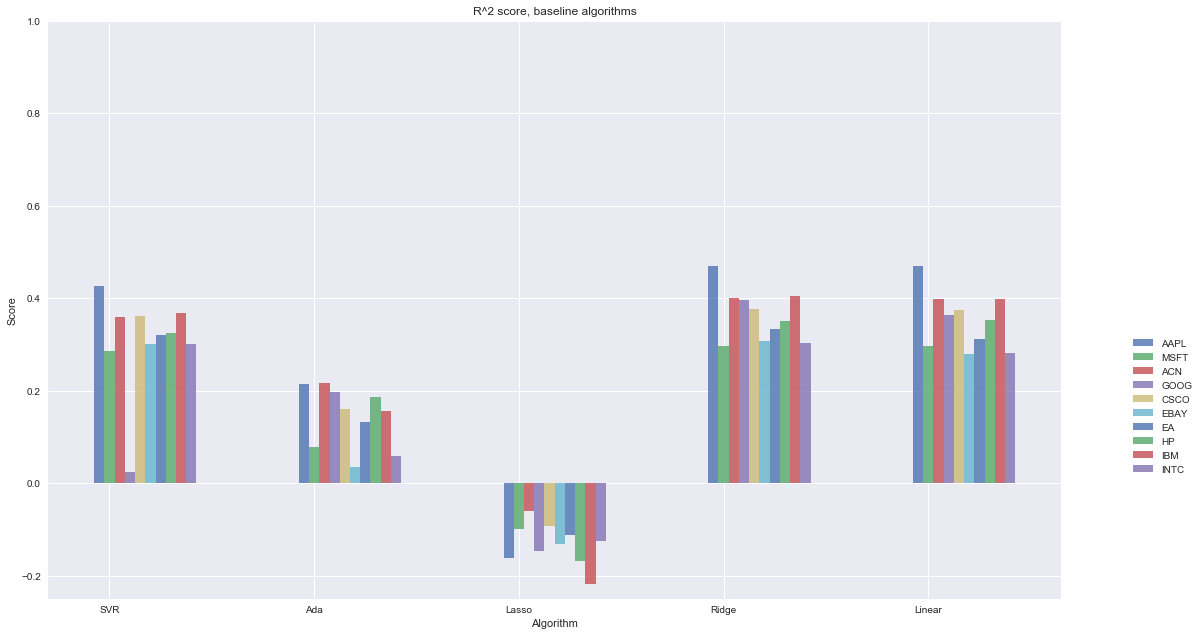

In [25]:
PlotR2Score(scores_baseline, 'R^2 score, baseline algorithms', 'r2')

The best performing algorithms are Ridge and LinearRegression.

Identifyingy the optimal size of training set. 

Ridge


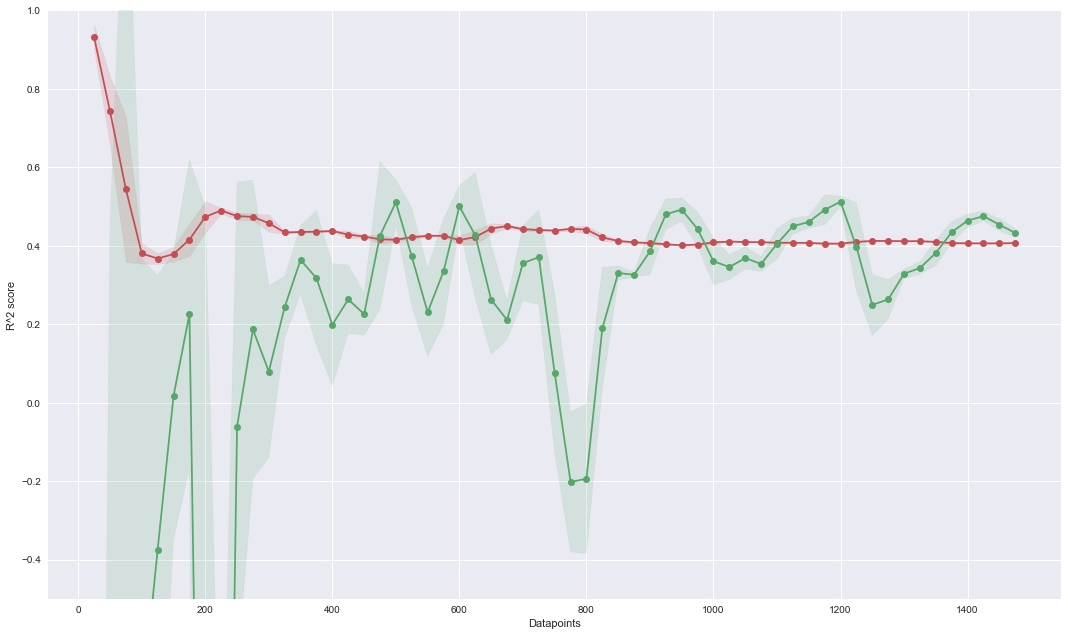

In [26]:
#import learning_curve as curves

def SlidingWindowSplit(fc, window, start_index, n_iter, step, testings_split_coef, ticker):
    
    features, labels, indexes = fc.GetData(ticker, predicting_day_index = 1, remove_NaN = True, predict_change = predict_change)
    
   
    dates = []
    for index in range(1, n_iter + 1):
        training_start_date = indexes[start_index]
        training_end_date = indexes[start_index + window - 1]
        testing_start_date = indexes[start_index + window]
        testing_end_date = indexes[start_index + window + int(ceil(window * testings_split_coef))]
        dates.append([training_start_date, training_end_date, testing_start_date, testing_end_date])
        start_index += step
        
    splits = []
    for training_start_date, training_end_date, testing_start_date, testing_end_date in dates: 
        training_data_indexes = indexes[(indexes >= training_start_date) \
                                                    & (indexes <= training_end_date)].index.tolist()
        testing_data_indexes = indexes[(indexes >= testing_start_date) \
                                                   & (indexes <= testing_end_date)].index.tolist()
        splits.append((np.array(training_data_indexes), np.array(testing_data_indexes)))

    return  splits
        

def ModelLearning(fc, regressors, start_index, window_max_size,  
                  ticker, pca_components = 15, predicting_day_index = 1, title = ""):
    """ Calculates the performance of several models using sliding window.
        The learning and testing scores for each model are then plotted. """

    features, labels, indexes = fc.GetData(ticker, predicting_day_index = predicting_day_index, remove_NaN = True, 
                                           predict_change = predict_change)
    
    k = 0
    fig, ax = plt.subplots()
    for regressor in regressors:  
        print(regressor.__class__.__name__)
        pipe_lr = Pipeline([     
                ('nrm', MinMaxScaler()),
                ('pca', PCA(n_components=pca_components)), 
                ('rgr', regressor)
               ])    
    
        n_iter = 5
        testings_split_coef = 0.1
        step= 10
        
        sizes = [] 
        train_scores = [] 
        test_scores = []
        
        for window in range(25, window_max_size, 25):
            splits = SlidingWindowSplit(fc, window = window, start_index = start_index, n_iter = n_iter,
                               step = step, testings_split_coef = testings_split_coef, ticker = ticker)
            
            local_test_scores = []
            local_train_scores = []
            for split in splits:
                X_train = features.iloc[split[0]]
                y_train = labels[split[0]]
                X_test = features.iloc[split[1]]
                y_test = labels[split[1]] 

                pipe_lr.fit(X_train, y_train)
                y_pred_train = pipe_lr.predict(X_train)
                y_pred_test = pipe_lr.predict(X_test)
                
                local_train_scores.append(r2_score(y_train, y_pred_train, multioutput='variance_weighted'))
                local_test_scores.append(r2_score(y_test, y_pred_test, multioutput='variance_weighted'))
                
            train_scores.append(np.array(local_train_scores))
            test_scores.append(np.array(local_test_scores))
            sizes.append(len(X_train))
           
        # Find the mean and standard deviation for smoothing
        train_std = np.std(np.array(train_scores), axis = 1)
        train_mean = np.mean(np.array(train_scores), axis = 1)
        test_std = np.std(np.array(test_scores), axis = 1)
        test_mean = np.mean(np.array(test_scores), axis = 1)

       
        plt.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        plt.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        plt.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')        
        plt.xlabel('Datapoints')
        plt.ylabel('R^2 score')        
        plt.ylim(-0.5, 1)
        plt.tight_layout()
        plt.show()            

start_index = 0

ModelLearning(fc, regressors = [Ridge()],
             start_index = start_index, window_max_size = 1500, ticker = 'INTC', 
             title = 'R^2 score with Ridge regression', pca_components = 20)        

As we can see up to 400 datapoints the Ridge regression generalization power is inconsistent and the model suffers from overfitting.

Refinement

We use GridSearchCV to identify best parameters for the selected models.

In [13]:
regressors = {
              'rgr1':LinearRegression(), 
              'rgr2':Ridge(),
              'rgr3':Lasso(), 
              'rgr4':AdaBoostRegressor(), 
              'rgr5':SVR()
             }

PARAM_RANGE_GAMMA = [0.001, 0.01, 0.1]
N_FEATURES_OPTIONS = [30, 35, 40]

param_grids = {
               'rgr1':[{'pca__n_components': N_FEATURES_OPTIONS, 'rgr__fit_intercept': [True]}], #LinearRegression
               'rgr2':[{'pca__n_components': N_FEATURES_OPTIONS, 'rgr__alpha': [0.0001, 0.001, 0.01, 0.1]}], #Ridge
               'rgr3':[{'pca__n_components': N_FEATURES_OPTIONS, 'rgr__alpha':[0.0001, 0.001, 0.01, 0.1]}], #Lasso
               'rgr4':[{'pca__n_components': N_FEATURES_OPTIONS, 'rgr__base_estimator':[LinearRegression()],  #AdaBoost
                           'rgr__n_estimators': [256, 512],
                           'rgr__learning_rate': [0.3, 0.4]}],
               'rgr5':[{'pca__n_components': N_FEATURES_OPTIONS, 'rgr__C': [10, 25, 50], 'rgr__gamma': PARAM_RANGE_GAMMA, 
                        'rgr__kernel': ['linear','rbf']
                       }]
              }


scores = []
for ticker in processing_tokens[:]:
    print(ticker)
    #get features and labels
    features_tuned = training_all[ticker][0]
    labels_tuned = training_all[ticker][1]
    date_indexes_tuned = training_all[ticker][2]
    #Normalize and remove outliers
    features_tuned, features_tuned = Normalize(features_tuned, features_tuned)
    features_tuned, labels_tuned = RemoveOutliers(features_tuned, labels_tuned, residual_threshold = 1.5) 
    #Assign X,y
    X_train_tuned = features_tuned
    y_train_tuned = labels_tuned
    #sequential train/test split 
    tscv = TimeSeriesSplit(n_splits=20)    
    for rgr in regressors:
        regressor = regressors[rgr]
        param_grid = param_grids[rgr]
        pipe_lr = Pipeline([
                        ('pca', PCA()), 
                        ('rgr', regressor)
                       ])
        
        gs = GridSearchCV(estimator=pipe_lr, 
                          param_grid=param_grid, 
                          scoring='r2',
                          cv=tscv,
                          n_jobs=-1)   
        gs = gs.fit(X_train_tuned, y_train_tuned)  
        
        start = time() 
        cvs_score_tuned = cross_validate(estimator=gs.best_estimator_, 
                      X = X_train_tuned,
                      y = y_train_tuned,
                      scoring=('r2', 'neg_mean_squared_error'),
                      cv = tscv,
                      n_jobs =-1)
        end = time()
        
        scores.append([
                       regressor.__class__.__name__, ticker, end - start, 
                       np.mean(np.array(cvs_score_tuned['train_r2'])),
                       np.absolute(np.mean(np.array(cvs_score_tuned['train_neg_mean_squared_error']))),
                       np.mean(np.array(cvs_score_tuned['test_r2'])),
                       np.absolute(np.mean(np.array(cvs_score_tuned['test_neg_mean_squared_error']))),
                       gs.best_params_, 
                       gs.best_estimator_ 
                      ])
        
         
scores_tuned = pd.DataFrame(scores, columns=['Algorithm','Ticker','Time','R2 train','MSE train','R2 test','MSE test',
                                            'Parameters','Estimator'])
ResultOutput(scores_tuned)

AAPL
MSFT
ACN
GOOG
CSCO
EBAY
EA
HP
IBM
INTC
SPY
   Algorithm Ticker   Time  R2 train  MSE train   R2 test  MSE test  \
0        SVR   AAPL  8.720  0.650454   0.124808  0.484676  0.198690   
5        SVR   MSFT  8.272  0.524493   0.040475  0.346080  0.060162   
10       SVR    ACN  8.205  0.573875   0.073814  0.374214  0.130470   
18     Ridge   GOOG  8.128  0.807916   0.965585  0.436105  2.005670   
22     Lasso   CSCO  8.891  0.602840   0.009578  0.333615  0.014376   
25       SVR   EBAY  8.125  0.540257   0.013146  0.341424  0.020661   
30       SVR     EA  8.429  0.594098   0.064265  0.324834  0.132867   
37     Lasso     HP  8.131  0.582911   0.177705  0.355788  0.252175   
40       SVR    IBM  8.313  0.566892   0.231351  0.338042  0.252093   
45       SVR   INTC  8.185  0.517349   0.023567  0.333560  0.031172   
50       SVR    SPY  8.262  0.569505   0.147122  0.371201  0.212855   

                                           Parameters  \
0   {u'rgr__gamma': 0.01, u'pca__n_compone

In [21]:
benchmark_df1 = benchmark_df.copy()
idx1 = benchmark_df1.groupby(['Ticker'])['R2 test'].transform(max) == benchmark_df1['R2 test']
benchmark_df1 = benchmark_df1[idx1]

tuned_df1 = scores_tuned.copy()
idx2 = tuned_df1.groupby(['Ticker'])['R2 test'].transform(max) == tuned_df1['R2 test']
tuned_df1 = tuned_df1[idx2]

#scores_tuned

In [29]:
benchmark_df1
tuned_df1
compare_df = benchmark_df1.merge(tuned_df1, how = 'inner', left_on = ['Ticker'], right_on = ['Ticker'])
compare_df
compare_df['Delta R2 train'] = pd.Series(compare_df['R2 train_y'] - compare_df['R2 train_x'])
compare_df['Delta R2 test'] = pd.Series(compare_df['R2 test_y'] - compare_df['R2 test_x'])
compare_df['Delta MSE train'] = pd.Series(compare_df['MSE train_y'] - compare_df['MSE train_x'])
compare_df['Delta MSE test'] = pd.Series(compare_df['MSE test_y'] - compare_df['MSE test_x'])
compare_df['Best model'] = pd.Series(compare_df['Algorithm_y'])
compare_df[['Ticker','Best model','Delta MSE test','Delta MSE train','Delta R2 test','Delta R2 train']]

,Ticker,Best model,Delta MSE test,Delta MSE train,Delta R2 test,Delta R2 train
0,AAPL,SVR,-0.015186,0.094211,0.075112,-0.259225
1,MSFT,SVR,-0.010638,0.030279,0.177659,-0.351582
2,ACN,SVR,-0.012714,0.053759,0.060495,-0.304056
3,GOOG,Ridge,0.533281,0.770801,-0.174779,-0.152828
4,CSCO,Lasso,-0.001511,0.007318,0.047338,-0.299816
5,EBAY,SVR,-0.007742,0.009738,0.225625,-0.340874
6,EA,SVR,-0.007335,0.048919,0.044359,-0.305321
7,HP,Lasso,-0.043212,0.134750,0.124169,-0.307523
8,IBM,SVR,-0.003397,0.184051,0.018601,-0.345062
9,INTC,SVR,-0.003009,0.018473,0.094006,-0.379434


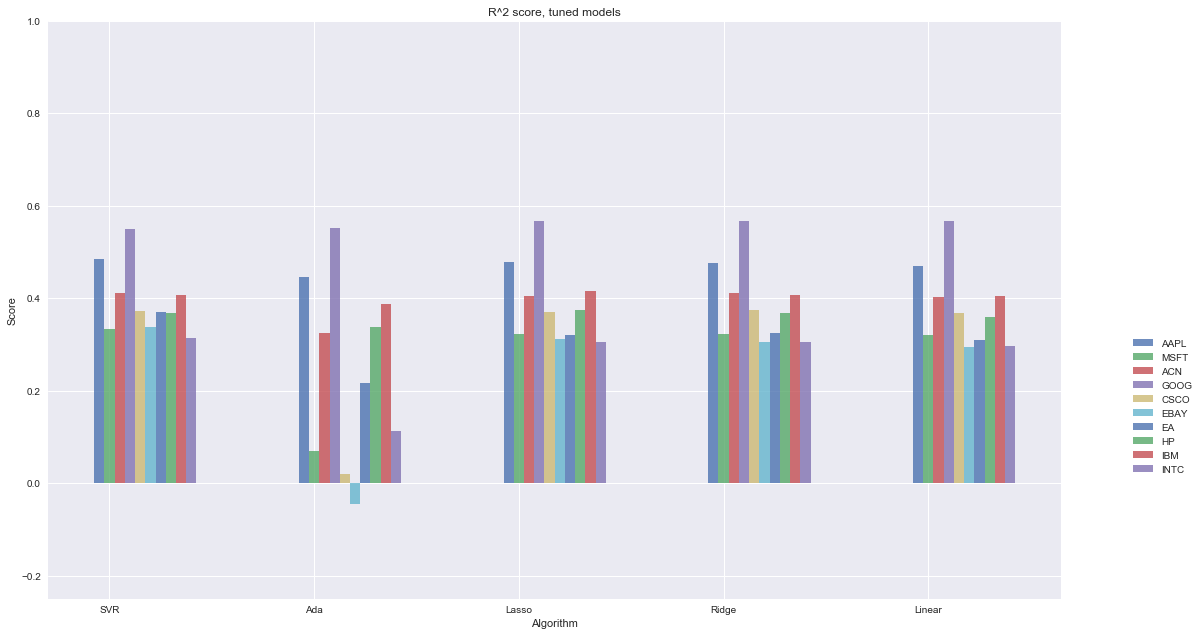

In [30]:
PlotR2Score(scores_tuned, 'R^2 score, tuned models', 'r2')

Validation

To validate the robustness of the algorithm we use a backtesting. The idea is to execute the choosen model on past data that never used for training. We use sliding window techinque to generate training and testing se to make sure that testing data is always after training. 

In [14]:
ticker = 'HP'
start_index = 0
training_size = 500
testing_size = 100
predicting_day_index = 1
step = 100
n_iter_max = 5

scores = []
for ticker in processing_tokens[:]:
    if ticker != 'GOOG':
        #find best regressor from scores_tuned
        best_scored_df = scores_tuned.sort_values('R2 test', ascending=False).\
            groupby('Ticker', as_index=False).first()
        pipe_lr = best_scored_df.at[best_scored_df[(best_scored_df['Ticker'] == ticker)]['Estimator'].index[0], 'Estimator']

        #get features and labels
        features_valid = validation_all[ticker][0]
        labels_valid = validation_all[ticker][1]
        date_indexes_valid = validation_all[ticker][2]

        r2 = []
        mse = []
        for i in range(0, n_iter_max):    
            #get window
            features_valid_iter = features_valid[start_index + i * step:start_index + i * step + training_size + testing_size]
            labels_valid_iter = labels_valid[start_index + i * step:start_index + i * step + training_size + testing_size]

            #Normalize and remove outliers
            features_valid_iter, features_valid_iter = Normalize(features_valid_iter, features_valid_iter)
            features_valid_iter, labels_valid_iter = RemoveOutliers(features_valid_iter, labels_valid_iter, residual_threshold = 1.5) 

            X_train = features_valid_iter[:500]
            y_train = labels_valid_iter[:500]
            X_test = features_valid_iter[500:]
            y_test = labels_valid_iter[500:]

            pipe_lr.fit(X_train, y_train)
            y_train_pred = pipe_lr.predict(X_train)
            y_test_pred = pipe_lr.predict(X_test)

            r2.append(r2_score(y_test, y_test_pred, multioutput='variance_weighted'))
            mse.append(mean_squared_error(y_test, y_test_pred))

        scores.append([
               ticker, 
               np.mean(np.array(r2)),
               np.mean(np.absolute(np.array(mse))),
               np.std(np.array(y_test)),
               np.std(np.array(y_test_pred)),
               np.mean(np.array(y_test)),
               np.mean(np.array(y_test_pred))
              ])

validation_df =  pd.DataFrame(scores, columns=['Ticker','R2 test','MSE test', 'test_std', 'pred_std', 'test_mean', 'pred_mean'])
validation_df

,Ticker,R2 test,MSE test,test_std,pred_std,test_mean,pred_mean
0,AAPL,0.479823,0.156369,0.442764,0.344590,0.223977,0.118822
1,MSFT,0.351194,0.026464,0.265800,0.151910,0.066364,0.041937
2,ACN,0.499599,0.090108,0.485027,0.271368,0.111099,0.048834
3,CSCO,0.380198,0.015624,0.172246,0.098133,0.005600,0.020226
4,EBAY,0.356481,0.019638,0.192777,0.097345,-0.019900,0.007089
5,EA,0.307486,0.026597,0.201750,0.103191,0.010928,0.046680
6,HP,0.410325,0.121962,0.313226,0.201612,0.117727,0.034933
7,IBM,0.478973,0.330168,0.838173,0.506707,-0.063929,-0.076338
8,INTC,0.322845,0.017627,0.150754,0.088807,0.000500,-0.003564
9,SPY,0.399594,0.178123,0.420148,0.252525,0.179670,0.013568


In [17]:
validation_df['Delta_std'] = pd.Series((validation_df['test_std'] - validation_df['pred_std'])/validation_df['test_std']*100)
validation_df['Delta_mean'] = pd.Series((validation_df['test_mean'] - validation_df['pred_mean'])/validation_df['test_mean']*100)
validation_df.sort_values(['R2 test'], ascending = False)

,Ticker,R2 test,MSE test,test_std,pred_std,test_mean,pred_mean,Delta_std,Delta_mean
2,ACN,0.499599,0.090108,0.485027,0.271368,0.111099,0.048834,44.051087,56.044832
0,AAPL,0.479823,0.156369,0.442764,0.344590,0.223977,0.118822,22.172924,46.949188
7,IBM,0.478973,0.330168,0.838173,0.506707,-0.063929,-0.076338,39.546321,-19.411731
6,HP,0.410325,0.121962,0.313226,0.201612,0.117727,0.034933,35.633857,70.327430
9,SPY,0.399594,0.178123,0.420148,0.252525,0.179670,0.013568,39.896109,92.448545
3,CSCO,0.380198,0.015624,0.172246,0.098133,0.005600,0.020226,43.027390,-261.174609
4,EBAY,0.356481,0.019638,0.192777,0.097345,-0.019900,0.007089,49.503739,135.621737
1,MSFT,0.351194,0.026464,0.265800,0.151910,0.066364,0.041937,42.847926,36.807504
8,INTC,0.322845,0.017627,0.150754,0.088807,0.000500,-0.003564,41.091702,812.814884
5,EA,0.307486,0.026597,0.201750,0.103191,0.010928,0.046680,48.852191,-327.162988


Our model succesfully passed validation phase. 
Run a prediction for a remaining data using best model.

Results

To complete the analysis we run the choosen model to predict prices for the k-days after training set end date, where k = 5. 

In [40]:
ticker = 'IBM'
start_index = 2800
training_size = 400

#find best regressor from scores_tuned
best_scored_df = scores_tuned.sort_values('R2 test', ascending=False).\
    groupby('Ticker', as_index=False).first()
pipe_lr = best_scored_df.at[best_scored_df[(best_scored_df['Ticker'] == ticker)]['Estimator'].index[0], 'Estimator']

# prediction = []
# actual = []
for predicting_day_index in range(1, 6):
    features_pred, labels_pred, date_indexes = fc.GetData(ticker, predicting_day_index = predicting_day_index, 
                                                predict_change = predicting_day_index)
    features_norm, features_norm = Normalize(features_pred[start_index - training_size:-10], 
                                             features_pred[start_index - training_size:-10])
    X_train = features_pred[:training_size]
    y_train = labels_pred[:training_size]
    X_test = features_pred[training_size:training_size + 50]
    y_test = labels_pred[training_size:training_size + 50]
    X_train, y_train = RemoveOutliers(X_train, y_train, residual_threshold = 1.5) 

    pipe_lr.fit(X_train, y_train)
    y_train_pred = pipe_lr.predict(X_train)
    y_test_pred = pipe_lr.predict(X_test)    
    
    print("Predicting day - {}. Mean y_test - {}. Mean predicted - {}".format(predicting_day_index, 
                                                                             np.mean(y_test), np.mean(y_test_pred)))



Predicting day - 1. Mean y_test - 0.1086. Mean predicted - 0.0118133010109
Predicting day - 2. Mean y_test - 0.2146. Mean predicted - 0.0123378658124
Predicting day - 3. Mean y_test - 0.314. Mean predicted - -0.0569535062689
Predicting day - 4. Mean y_test - 0.4096. Mean predicted - 0.264029818833
Predicting day - 5. Mean y_test - 0.501. Mean predicted - -0.0219821483879


As expected, the accuracy of the prediction declines with increasing k. That happens because future price is mostly affected by the recent historical information as shown in the exctracting of important features phase. 

Portofolio performance

We calculate portfolio daily return using predicted data. Sharpe Ratio is used to evaluate a risk of the portfolio, the higher the ration value the lower the risk.

In [45]:
def annualised_sharpe(returns, N=252):
    """
    Calculate the annualised Sharpe ratio of a returns stream 
    based on a number of trading periods, N. N defaults to 252,
    which then assumes a stream of daily returns.

    The function assumes that the returns are the excess of 
    those compared to a benchmark.
    """
    return np.sqrt(N) * returns.mean() / returns.std()


def equity_sharpe(ticker, date):
    """
    Calculates the annualised Sharpe ratio based on the daily
    returns of an equity ticker symbol listed in Yahoo Finance.

    The dates have been hardcoded here for the QuantStart article 
    on Sharpe ratios.
    """

    # Obtain the equities daily historic data for the desired time period
    # and add to a pandas DataFrame
    full_df = stockData.raw_financial_data[ticker]
    pdf = full_df[full_df.index <= date]

    # Use the percentage change method to easily calculate daily returns
    pdf['daily_ret'] = pdf['Adj Close'].pct_change()

    # Assume an average annual risk-free rate over the period of 5%
    pdf['excess_daily_ret'] = pdf['daily_ret'] - 0.05/252

    # Return the annualised Sharpe ratio based on the excess daily returns
    return annualised_sharpe(pdf['excess_daily_ret'])


predicting_day_index = 1
prediction = []
for ticker in processing_tokens[:]:
    print(ticker)
    for predicting_day_index in range(1, 6):        
        #get features and labels    
        features, labels, date_indexes = fc.GetData(ticker, predicting_day_index = predicting_day_index,
                                                   predict_change = predict_change)
        features = features[-500:-50]
        labels = labels[-500:-50]
        date_indexes = date_indexes[-500:-50]

        X_train = features[-500:-100]
        y_train = labels[-500:-100]
        X_test = features[-100:-99]
        y_test = labels[-100:-99]
        date = date_indexes[y_train[-1:].index]

        #find best regressor from scores_tuned
        best_scored_df = scores_tuned.sort_values('R2 test', ascending=False).\
            groupby('Ticker', as_index=False).first()
        pipe_lr = best_scored_df.at[best_scored_df[(best_scored_df['Ticker'] == ticker)]['Estimator'].index[0], 'Estimator']
        
        pipe_lr.fit(X_train, y_train)
        y_pred = pipe_lr.predict(X_test)

        prediction.append([ticker, date.item(), equity_sharpe(ticker = ticker, date = date.item()), 
                           predicting_day_index, y_pred[0]])
        
df = pd.DataFrame(prediction, columns=['Ticker', 'Date', 'Sharpe', 'Day', 'EstimatedReturn'])
df.sort_values(['EstimatedReturn','Sharpe'], ascending = False)        

AAPL


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MSFT
ACN
GOOG
CSCO
EBAY
EA
HP
IBM
INTC
SPY


,Ticker,Date,Sharpe,Day,EstimatedReturn
19,GOOG,20170530,0.592107,5,4.597570
18,GOOG,20170530,0.592107,4,3.717739
17,GOOG,20170530,0.592107,3,2.490339
16,GOOG,20170530,0.592107,2,1.387786
34,EA,20170530,0.190932,5,0.664897
54,SPY,20170530,0.232889,5,0.640896
33,EA,20170530,0.190932,4,0.539909
4,AAPL,20170519,0.893235,5,0.533994
53,SPY,20170530,0.232889,4,0.507994
15,GOOG,20170530,0.592107,1,0.484285
